# Content
Time series clustering using K means with Euclidean and DTW distance

How to decide the number of clusters ?

How can we calculate performance of clustering ?

In [1]:
%matplotlib inline
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd

tslearn is a Python package that provides machine learning tools for the analysis of time series.

# Data with three classes

In [2]:
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

X_train = X_train[y_train<4]
y_train = y_train[y_train<4]

X_test = X_test[y_test<4]
y_test = y_test[y_test<4]

In [3]:
X_train.shape

(69, 275, 1)

**We have actual class labels in this dataset, which is generally not available in real world clustering problems. So, we will use it just to compare different approaches**

## Note on pre-processing
**In this example, time series are preprocessed using TimeSeriesScalerMeanVariance.**
This scaler is such that each output time series has zero mean and unit variance.
The assumption here is that the range of a given time series is uninformative and one only wants to compare shapes.

In [4]:
seed = 0
np.random.seed(seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

## plot
Let's plot data, as groups based on provided labels

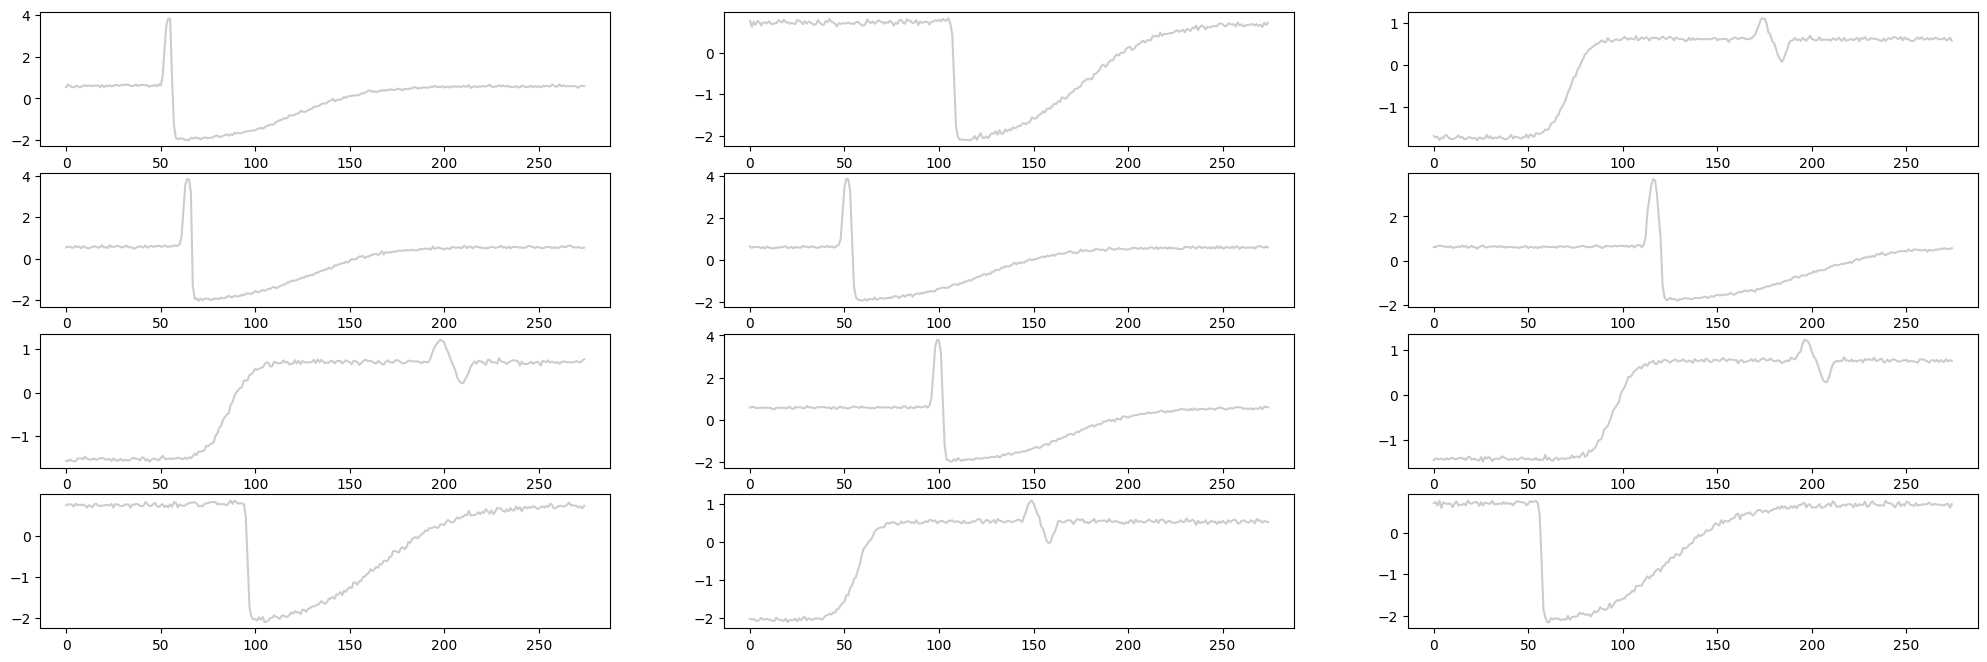

In [5]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

## No. of clusters decision

### Using inertia (sum of squared distances)

In [6]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

In [8]:
plt.plot(K, Sum_of_squared_distances['squared_dist'], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

TypeError: list indices must be integers or slices, not str

From above plot, we can see that after cluster = 3, plot flattens, so optimum number of clusters = 3

### Using Silhoutte score

For n_clusters = 2 The average silhouette_score is : 0.67
For n_clusters = 3 The average silhouette_score is : 0.45
For n_clusters = 4 The average silhouette_score is : 0.42
For n_clusters = 5 The average silhouette_score is : 0.38


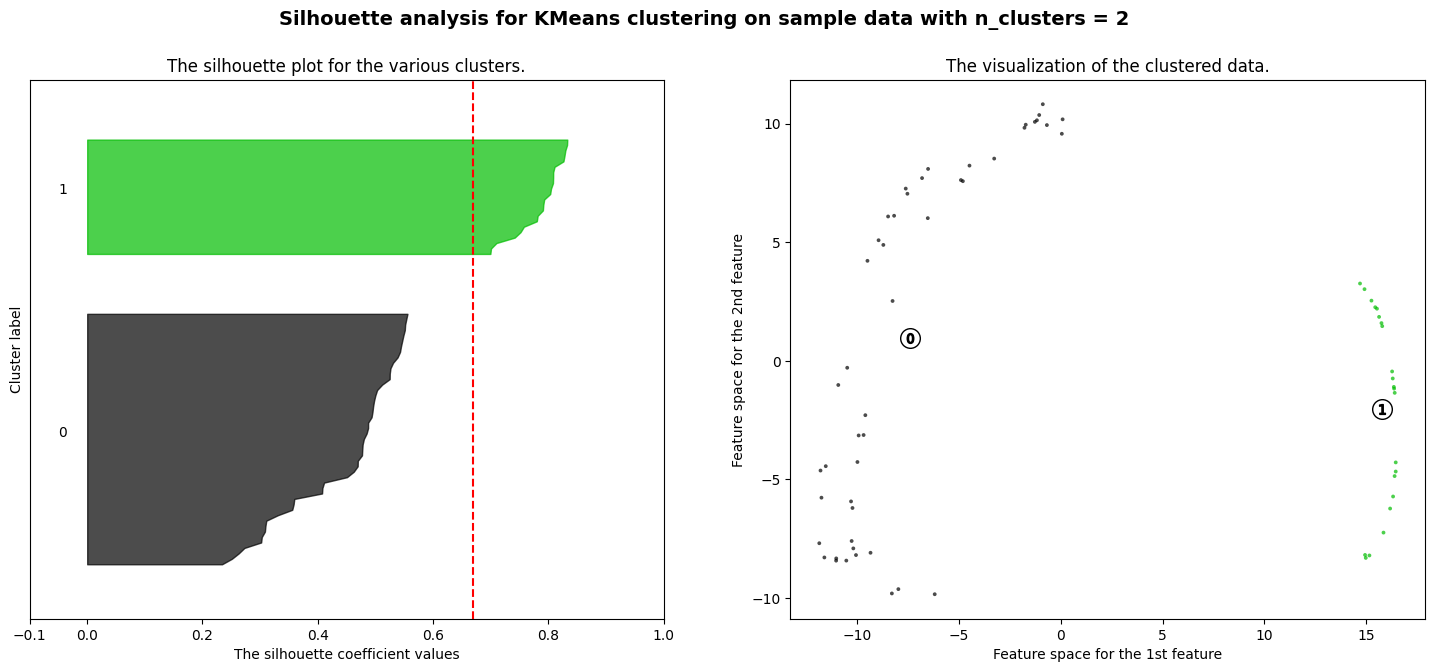

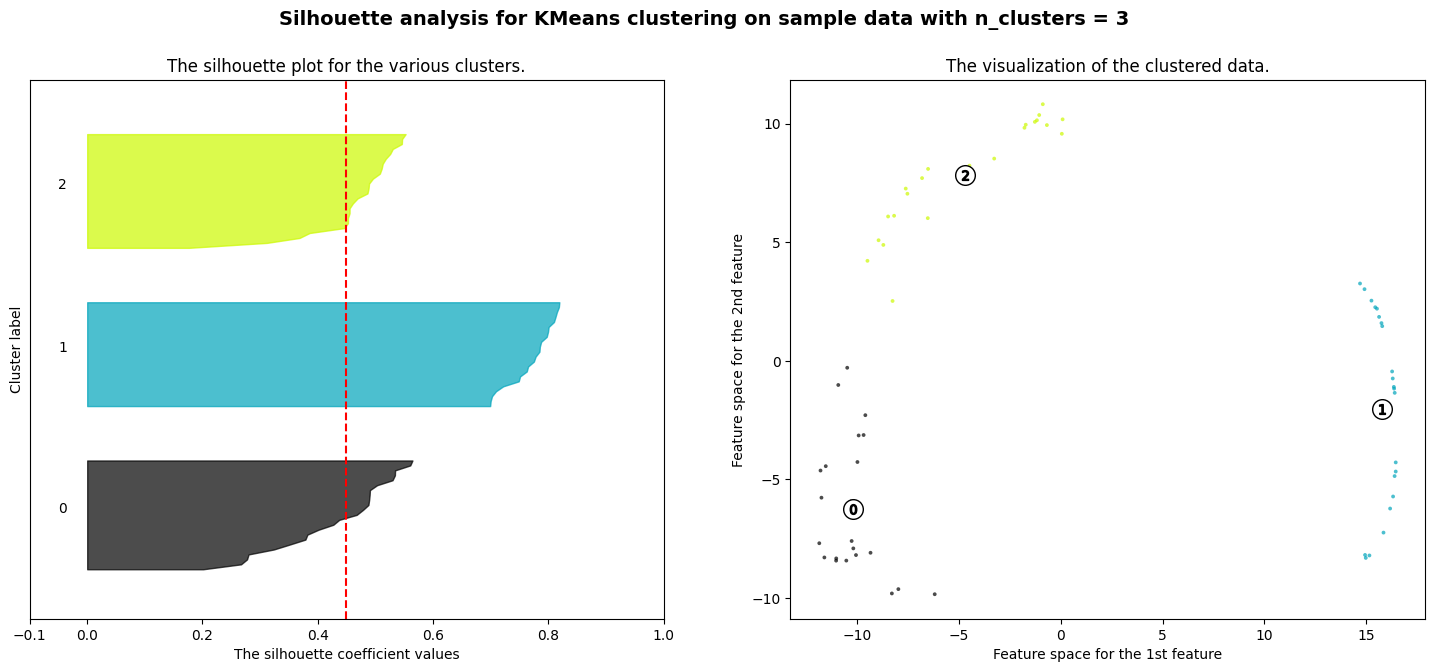

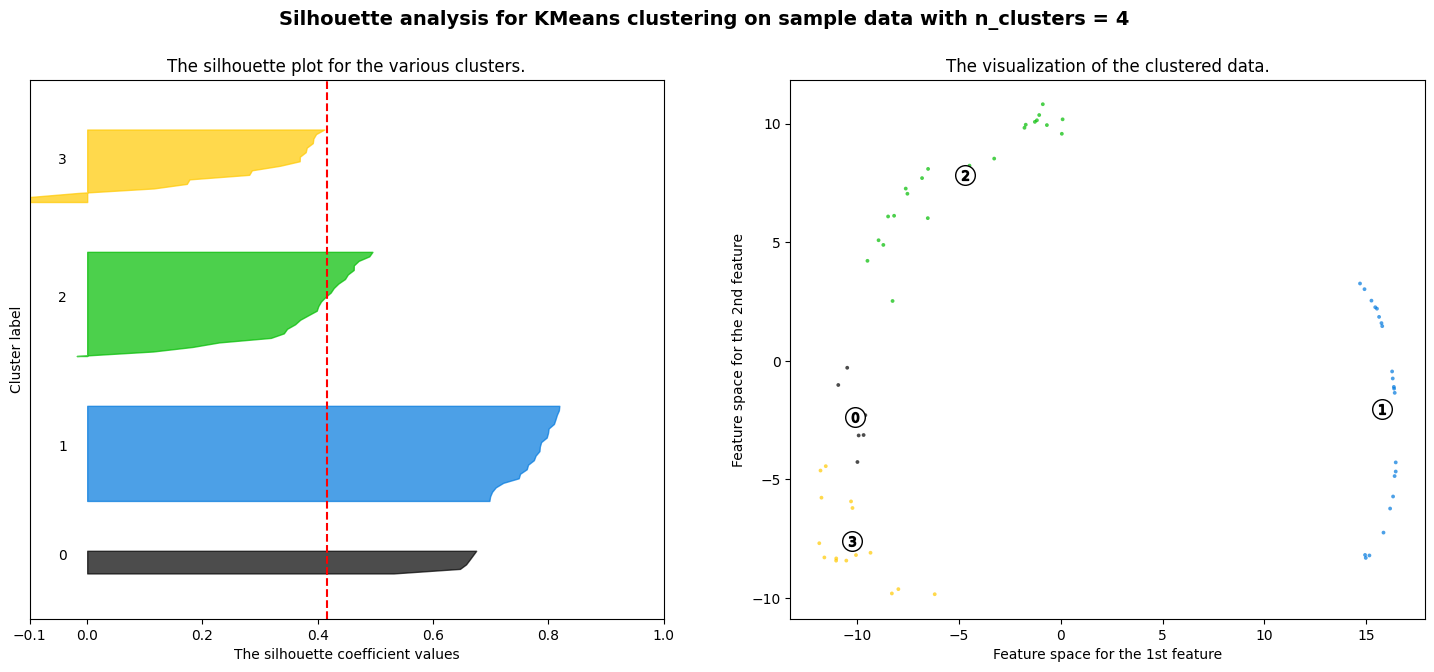

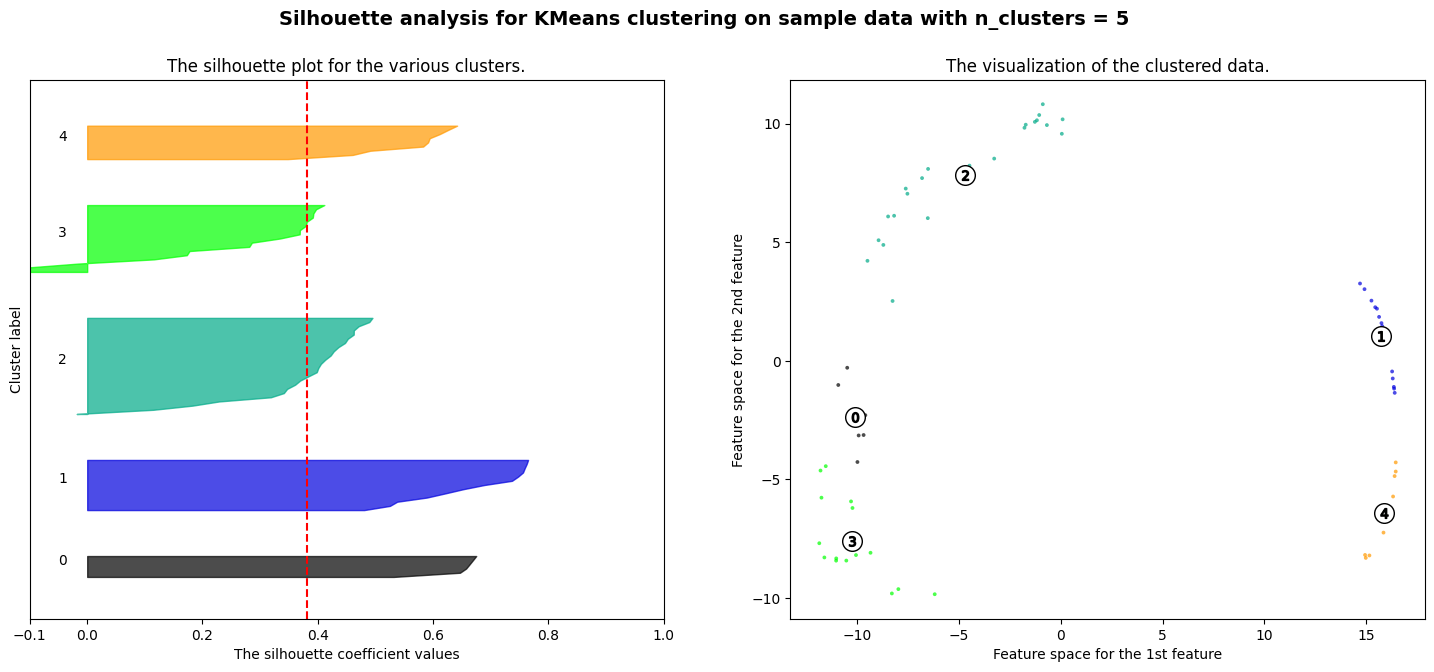

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

X = train_pca

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()


        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


## Actual clusters based on labels provided

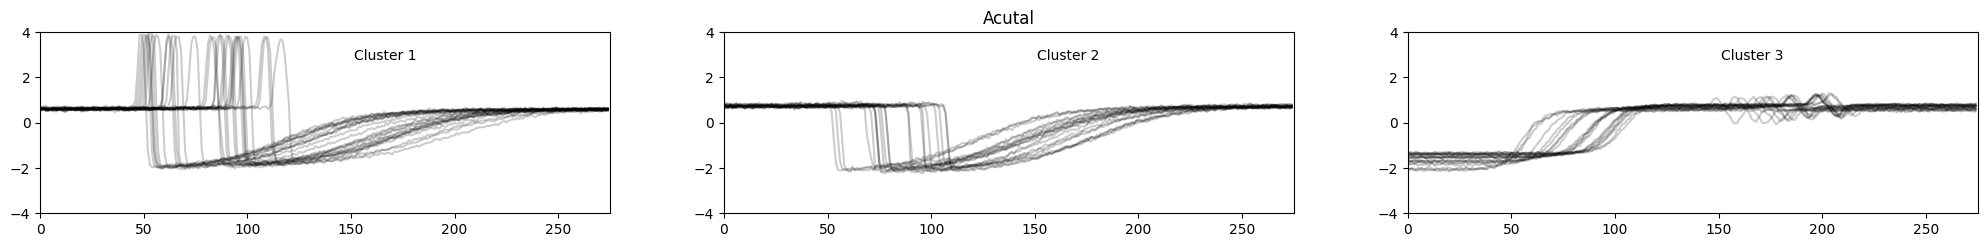

In [10]:
n_clusters = 3
sz = X_train.shape[1]
seed = 0

## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_train == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")

## Training the model
  - using Euclidean distance

Euclidean k-means
Euclidean silhoutte: 0.50


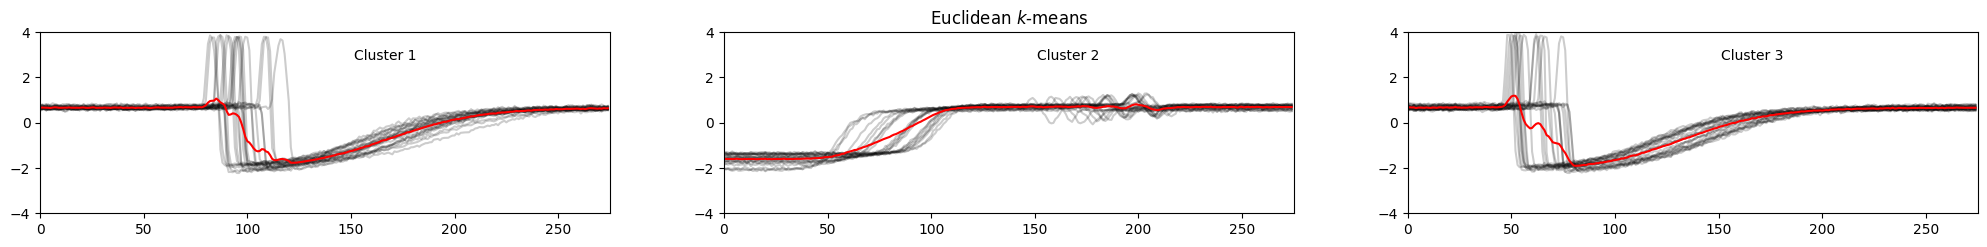

In [11]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X_train)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# Training the model
  - using DTW(Dynamic Time Warping) distance

DBA k-means
DBA silhoutte: 0.87


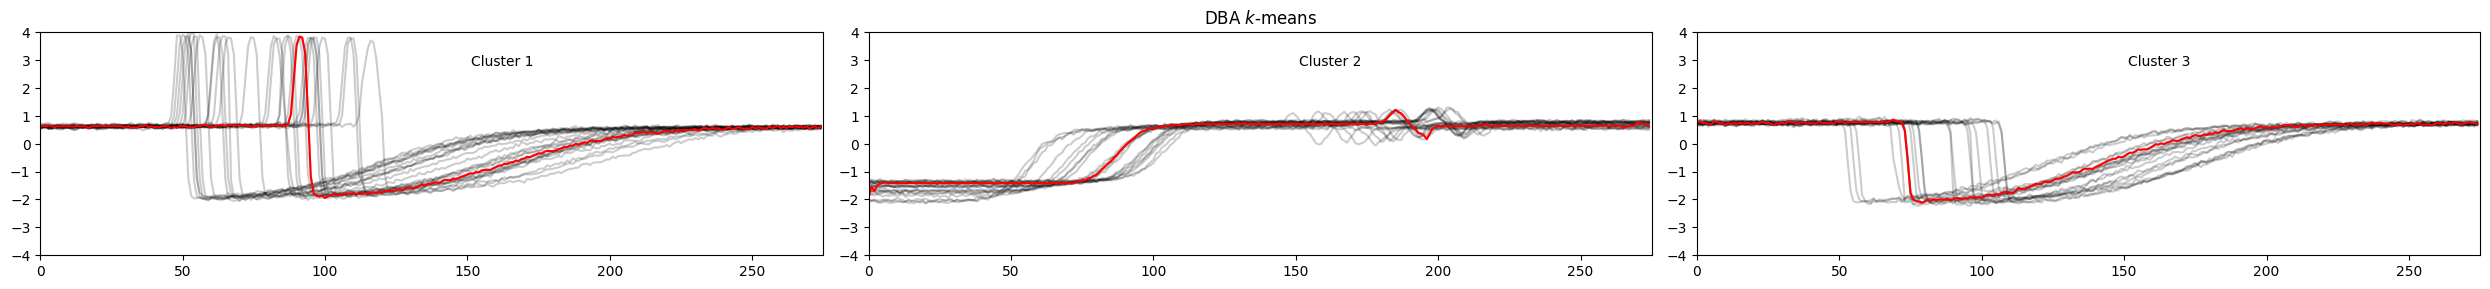

In [12]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")



plt.tight_layout()
plt.show()

**Verifying performance using Rand Index (calculated using labels y_train, so can't be calculated in real world use cases**

In [13]:
from sklearn import metrics

print("Adjusted Rand Index for Euclidean: {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_km)))
print("Adjusted Rand Index for DBA : {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_dba_km)))

Adjusted Rand Index for Euclidean: 0.47
Adjusted Rand Index for DBA : 1.00


# All plots together

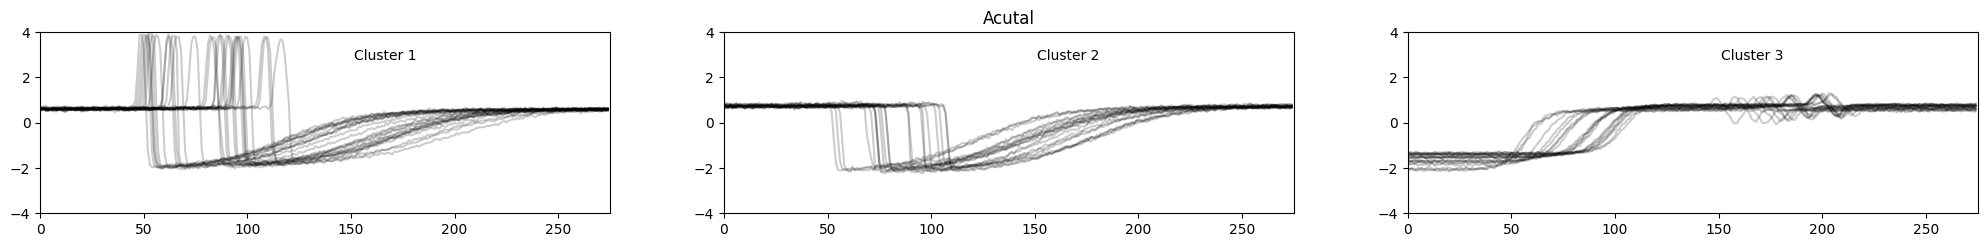

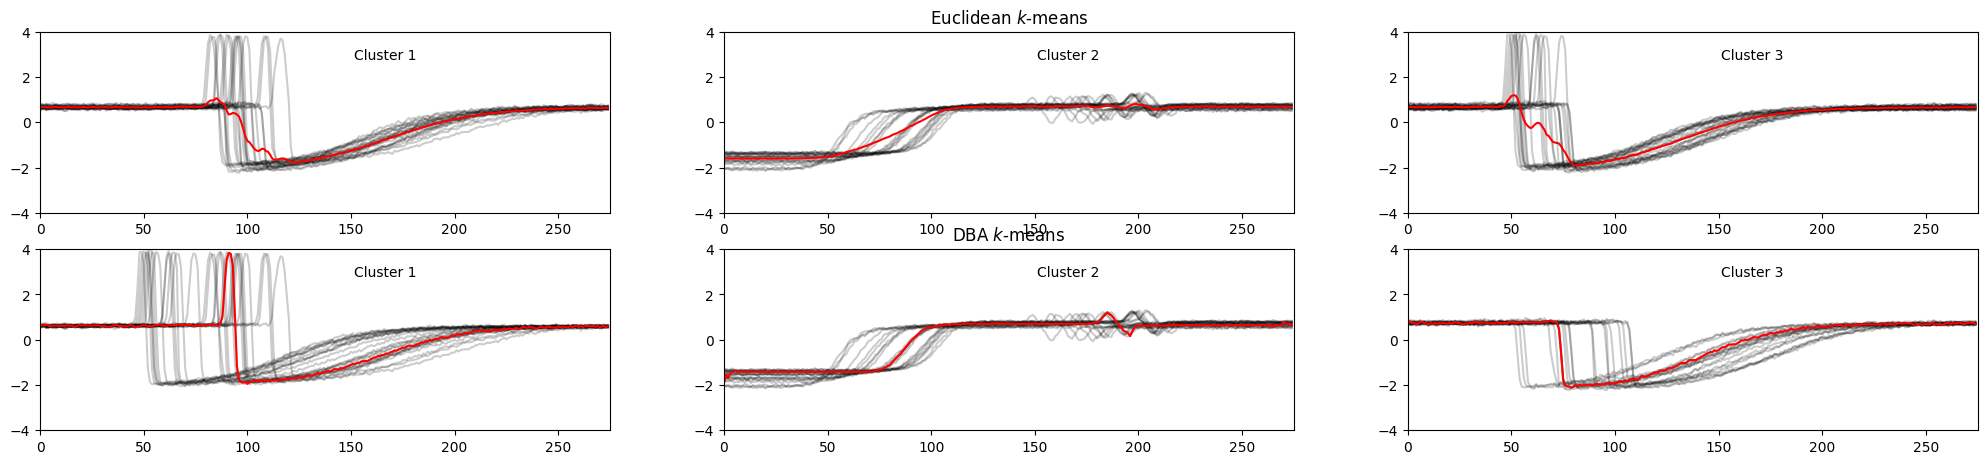

In [14]:
## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_train == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 4)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 7)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

## with PCA : improvement ?

silhoutte after PCA transformation: 0.44


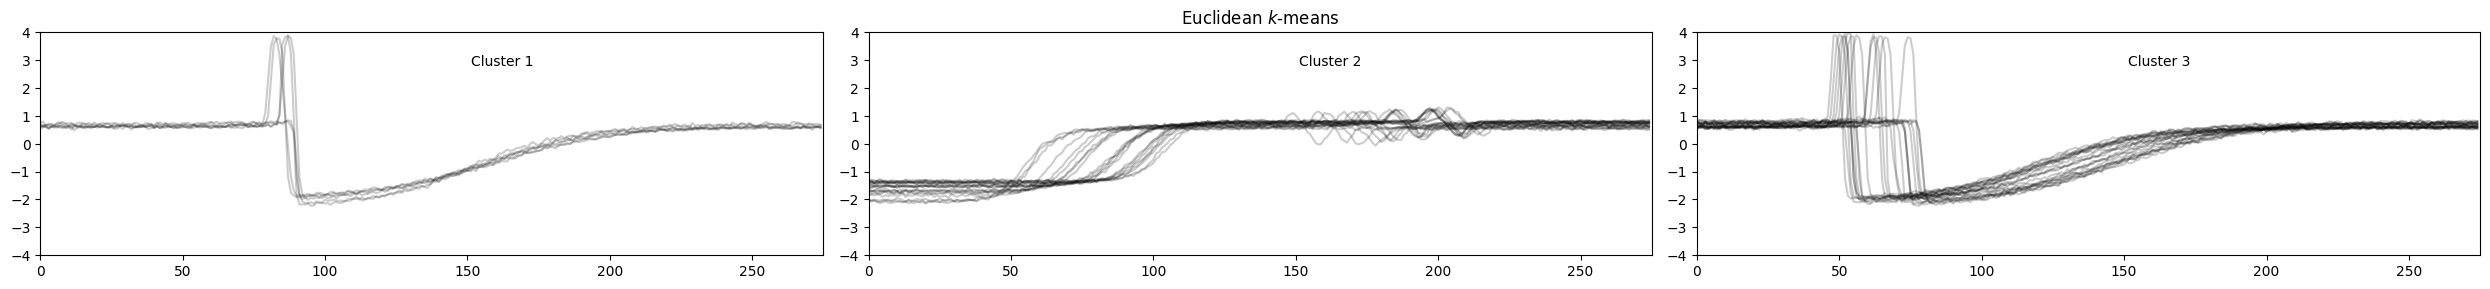

In [15]:
from sklearn.cluster import KMeans
import math

train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=4, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(train_pca)


print("silhoutte after PCA transformation: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)

    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.tight_layout()
plt.show()

In [16]:
print("Adjusted Rand Index after PCA: {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_km)))

Adjusted Rand Index after PCA: 0.44


## perfromance on test data

Euclidean k-means
Euclidean silhoutte: 0.49
DBA k-means
DBA silhoutte: 0.89


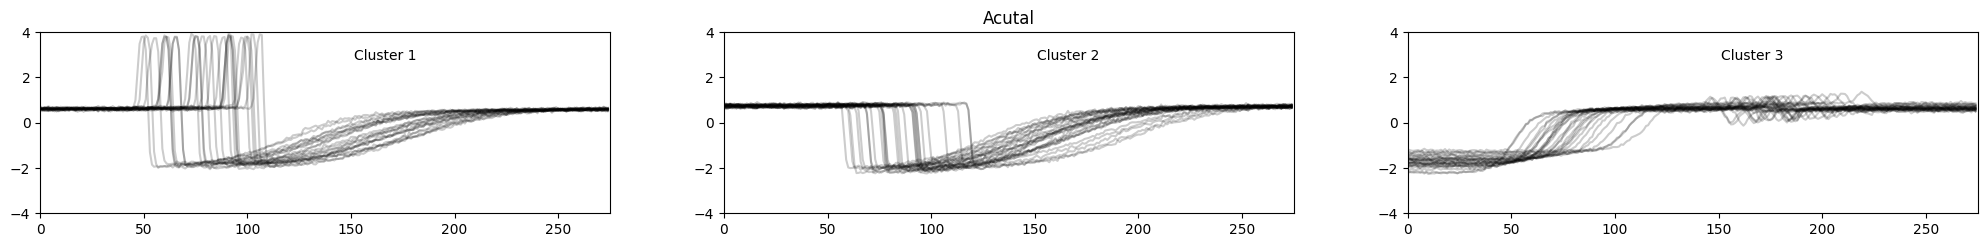

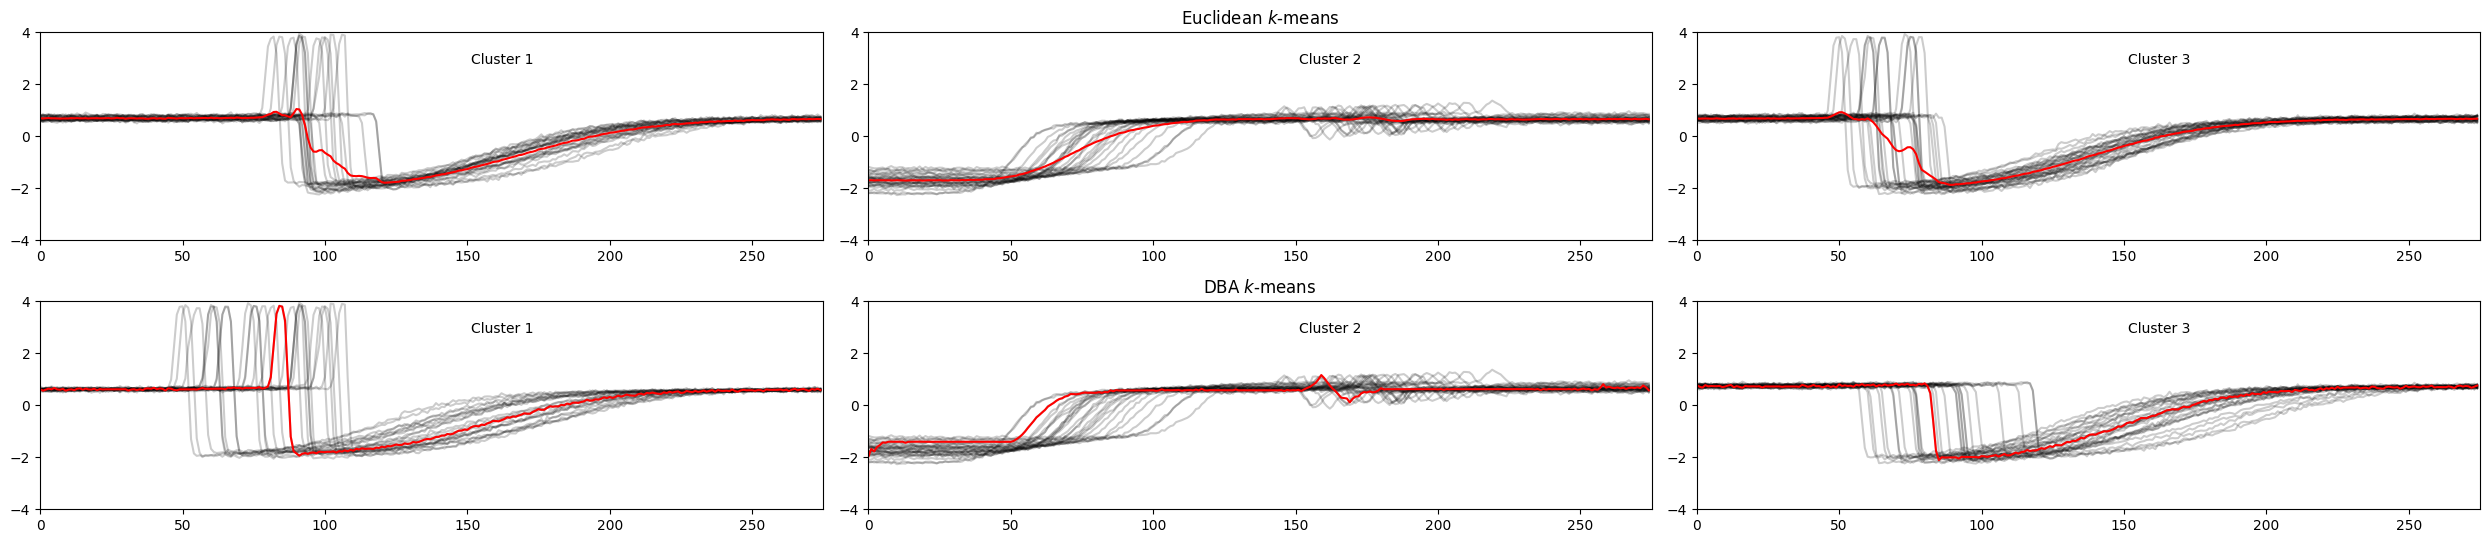

In [17]:
n_clusters = 3

## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_test[y_test == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")


# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X_test)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 4)
    for xx in X_test[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_test)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 7)
    for xx in X_test[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")



plt.tight_layout()
plt.show()

In [18]:
from sklearn import metrics

print("Adjusted Rand Index for Euclidean: {:.2f}".format(metrics.adjusted_rand_score(y_test, y_pred_km)))
print("Adjusted Rand Index for DBA : {:.2f}".format(metrics.adjusted_rand_score(y_test, y_pred_dba_km)))

Adjusted Rand Index for Euclidean: 0.51
Adjusted Rand Index for DBA : 1.00


# Data with Four classes

In [19]:
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

In [20]:
X_train.shape

(100, 275, 1)

In [21]:
seed = 0
np.random.seed(seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

## plot
Let's plot the sample data, first 12 time series

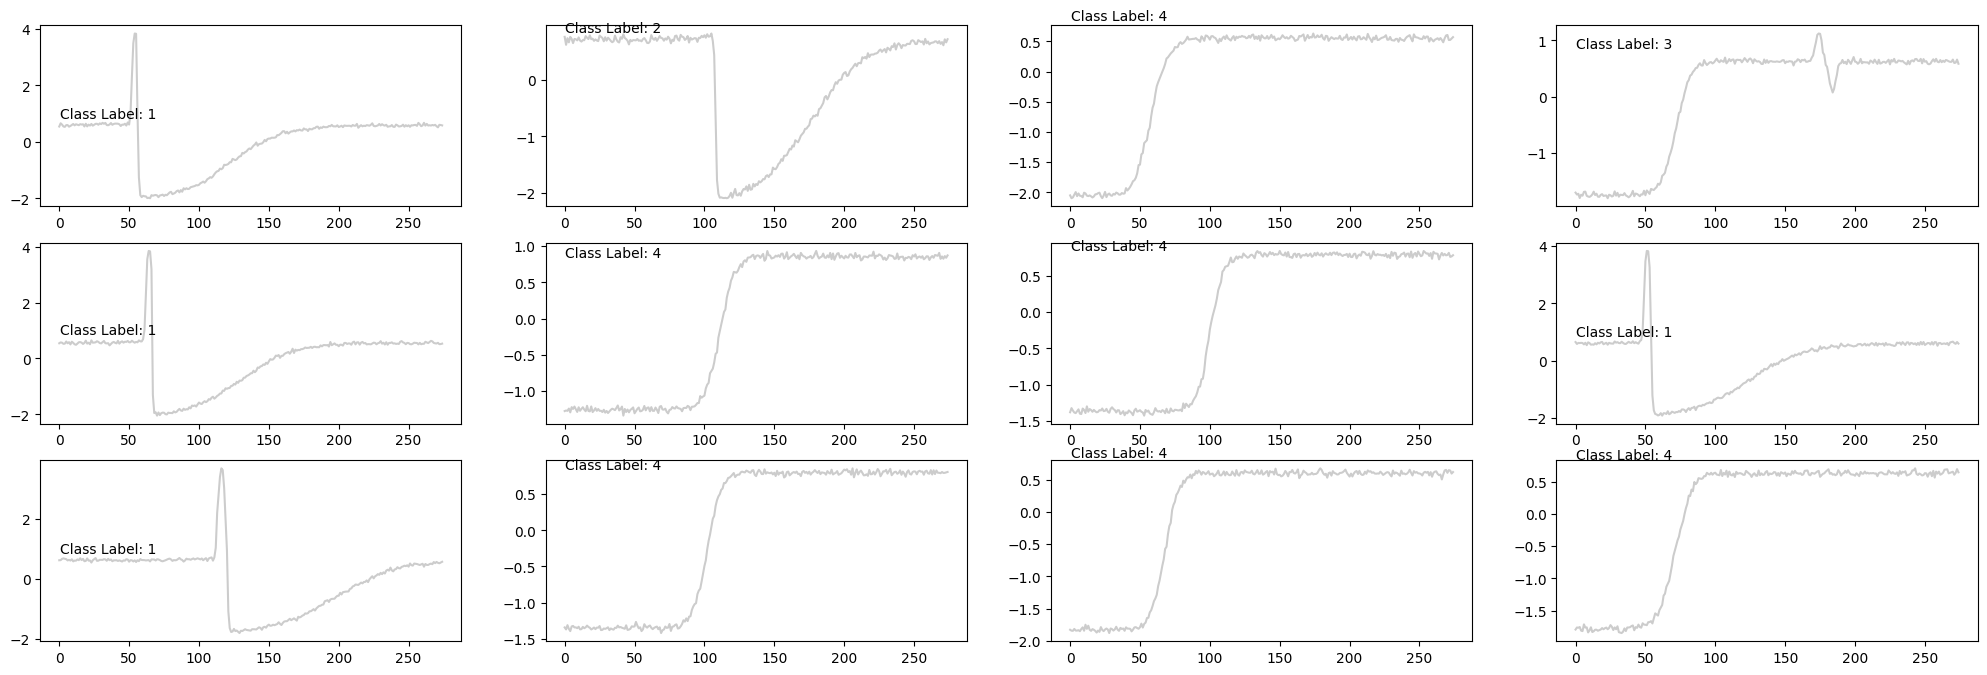

In [22]:
for yi in range(12):
    plt.subplot(3, 4, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

### No. of clusters decision

In [23]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

### Using inertia (sum of squared distances)

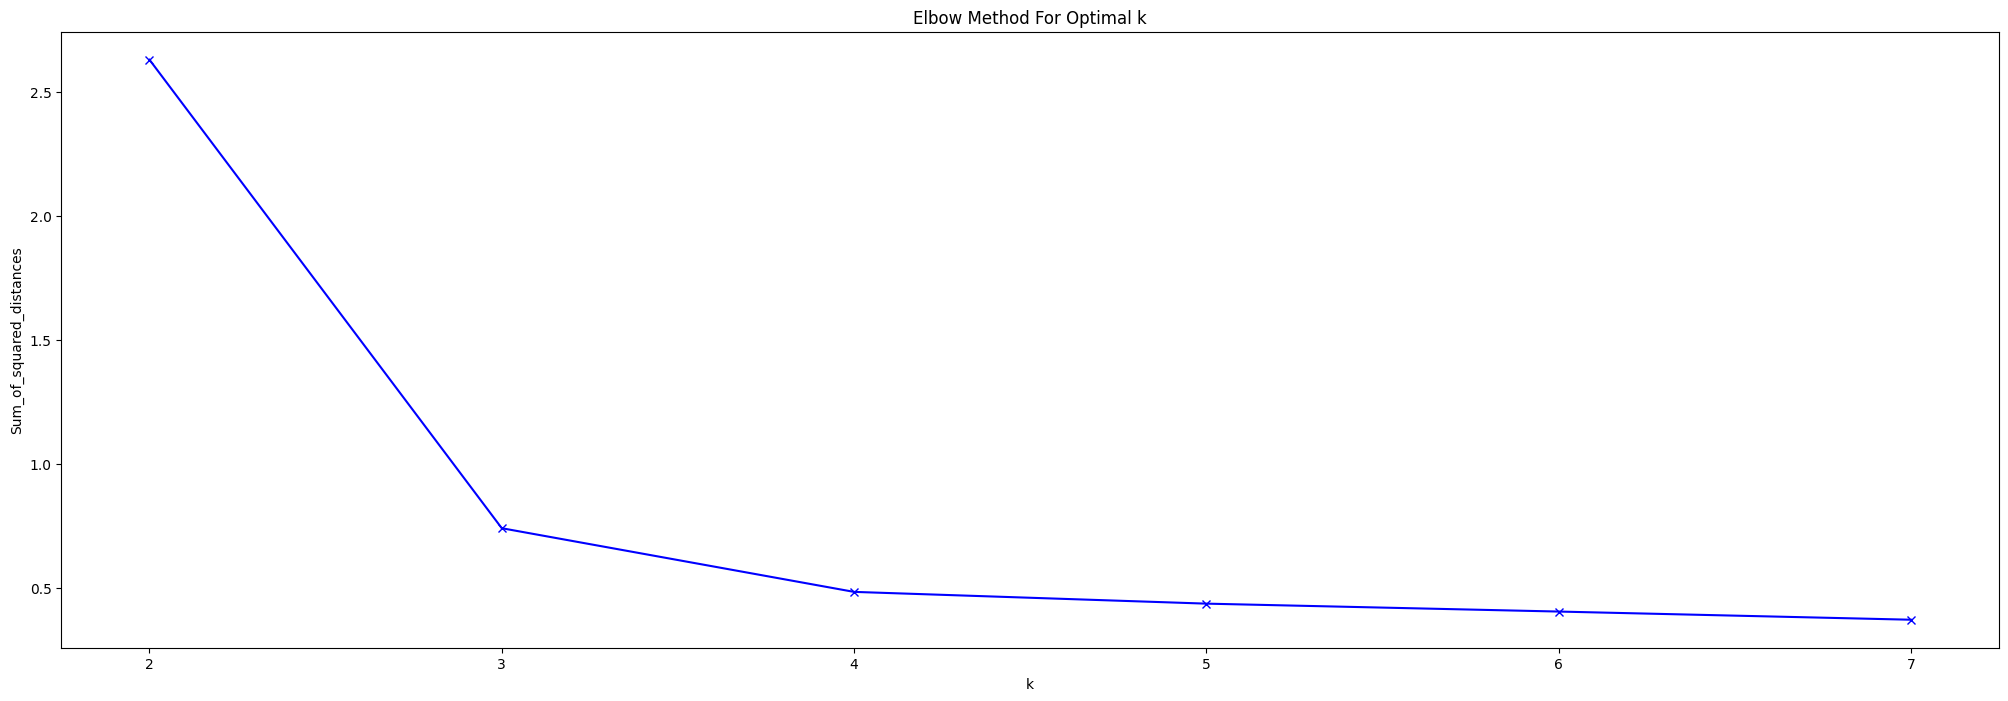

In [24]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot, we can see that after cluster =4, plot flattens, so optimum number of clusters = 4

### Using Silhoutte Score

For n_clusters = 3 The average silhouette_score is : 0.60
For n_clusters = 4 The average silhouette_score is : 0.49
For n_clusters = 5 The average silhouette_score is : 0.49
For n_clusters = 6 The average silhouette_score is : 0.47


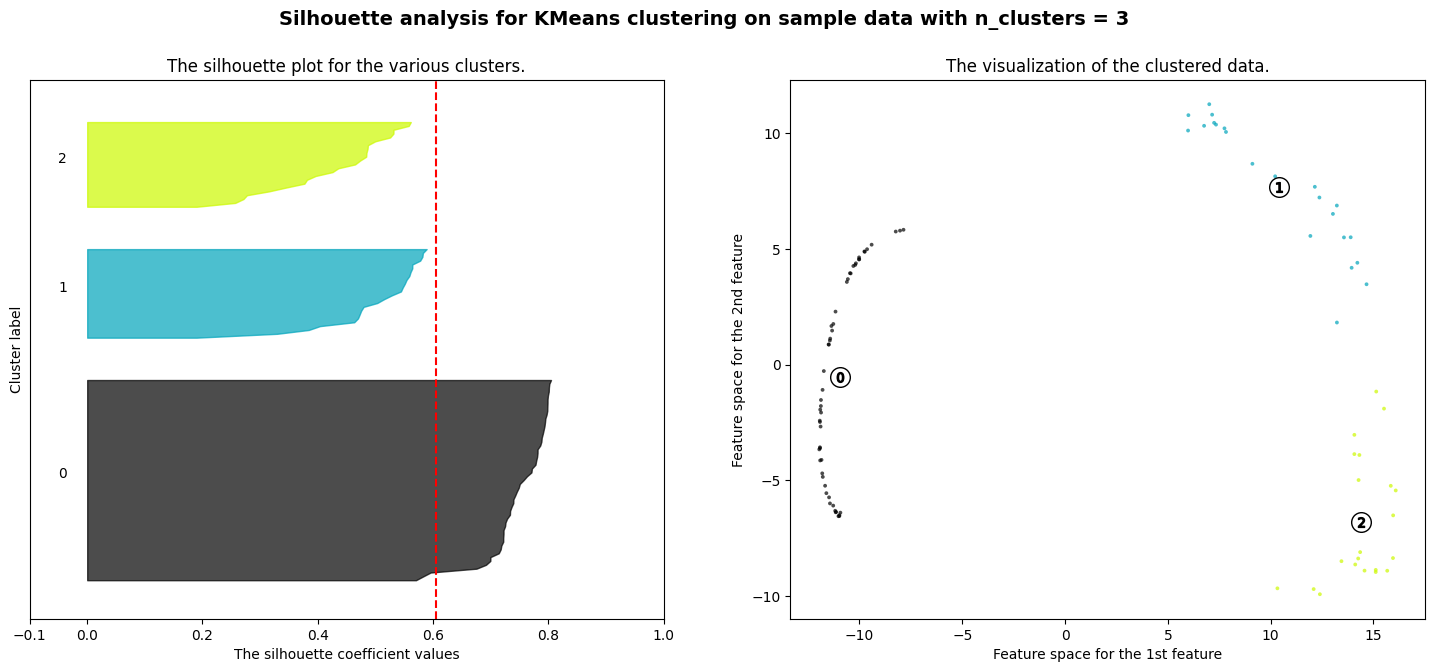

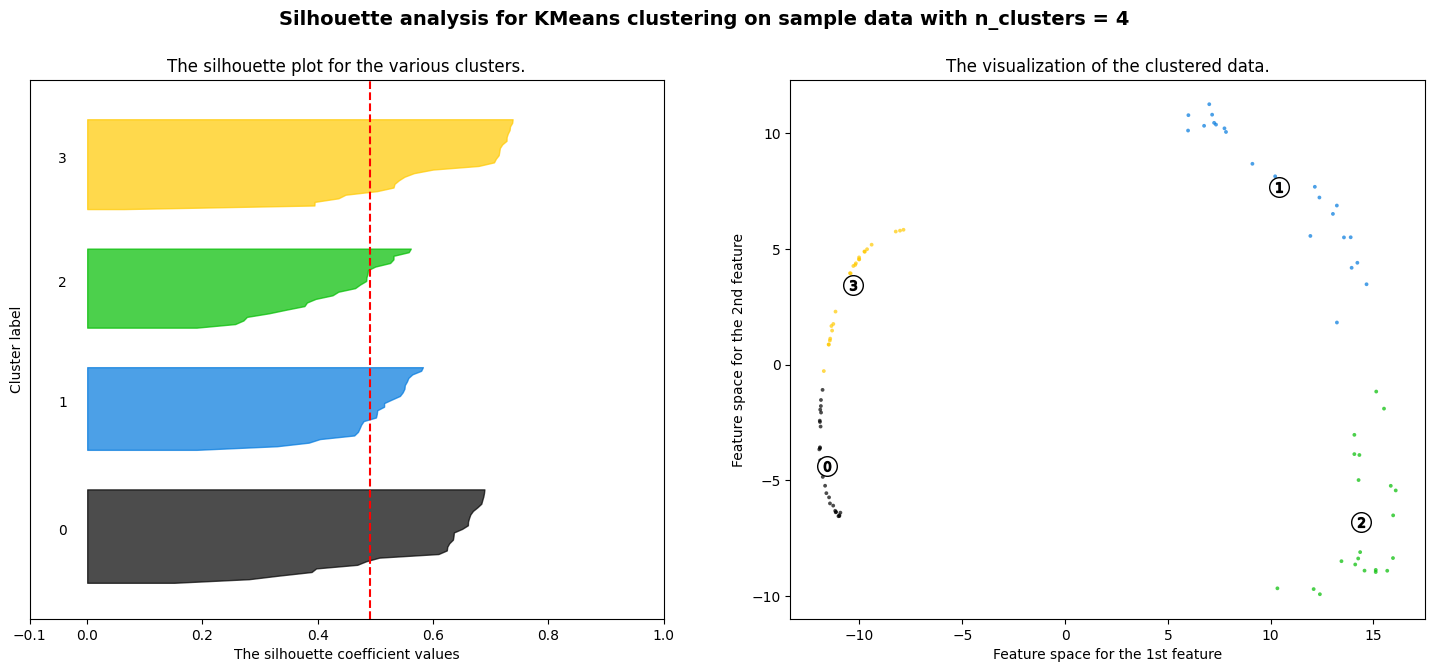

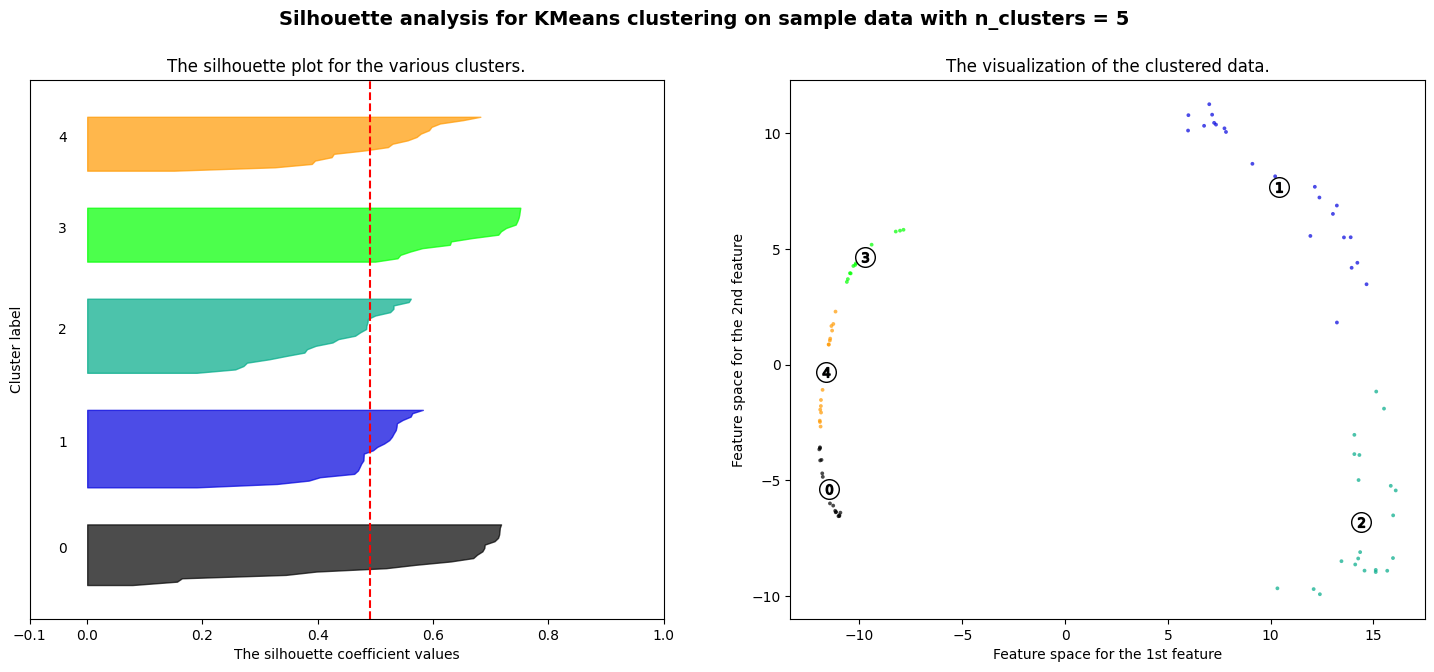

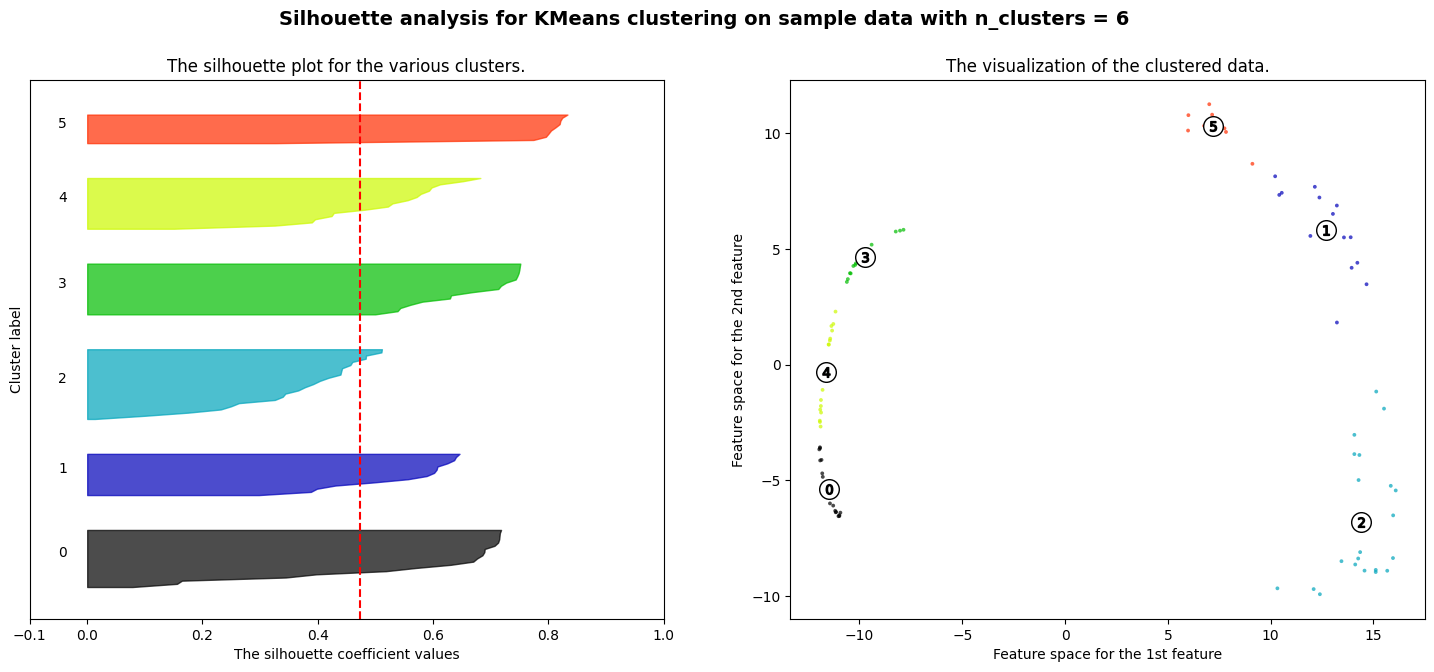

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

X = train_pca

range_n_clusters = [3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

#     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()


        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


## Training the model
  - using Euclidean distance
  - using DTW distance

Euclidean k-means
Euclidean silhoutte: 0.47
DBA k-means
DBA silhoutte: 0.69


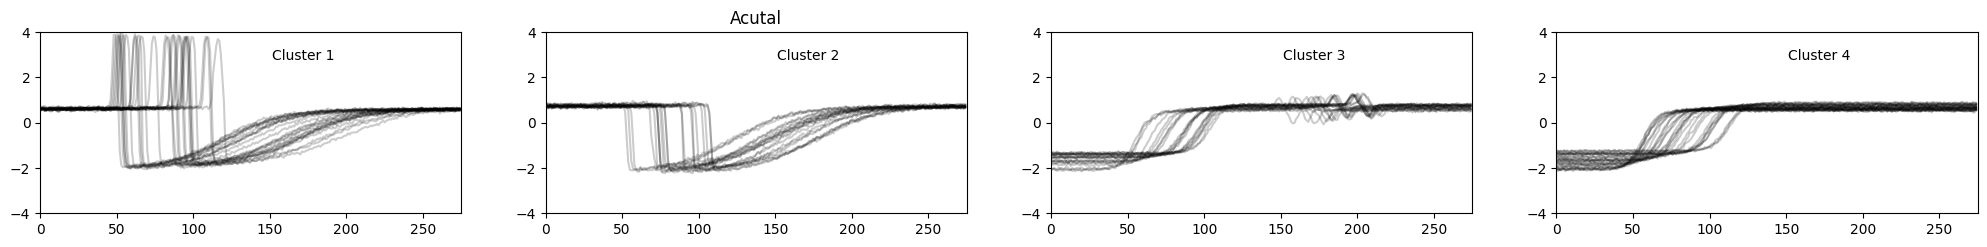

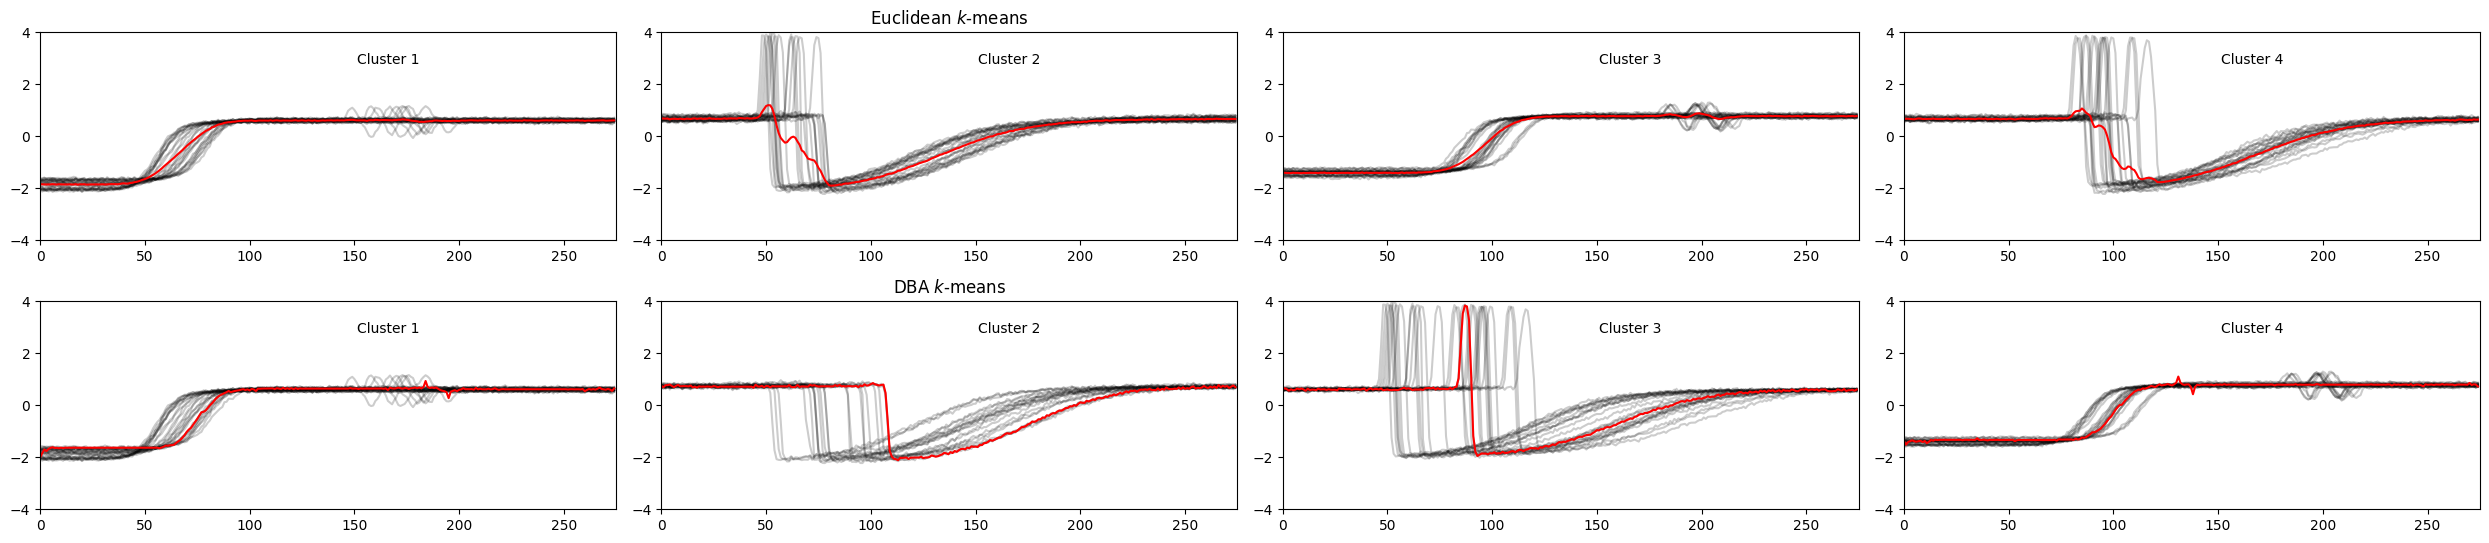

In [26]:
n_clusters = 4

## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_train == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")


# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X_train)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 5)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+9)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")



plt.tight_layout()
plt.show()

In [27]:
from sklearn import metrics

print("Adjusted Rand Index for Euclidean: {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_km)))
print("Adjusted Rand Index for DBA : {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_dba_km)))

Adjusted Rand Index for Euclidean: 0.33
Adjusted Rand Index for DBA : 0.63


## with PCA : improvement ?

silhoutte after PCA transformation: 0.47


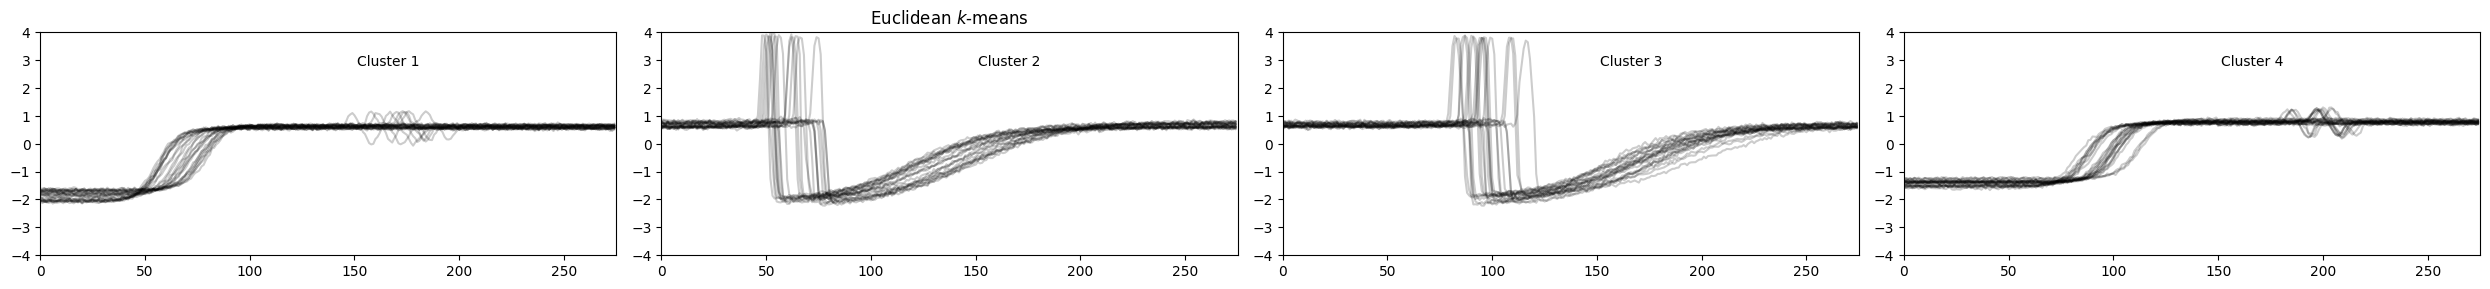

In [28]:
from sklearn.cluster import KMeans
import math

train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=4, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(train_pca)


print("silhoutte after PCA transformation: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(4):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.tight_layout()
plt.show()

In [29]:
print("Adjusted Rand Index after PCA: {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_km)))

Adjusted Rand Index after PCA: 0.33


## perfromance on test data

Euclidean k-means
Euclidean silhoutte: 0.38
DBA k-means
DBA silhoutte: 0.68


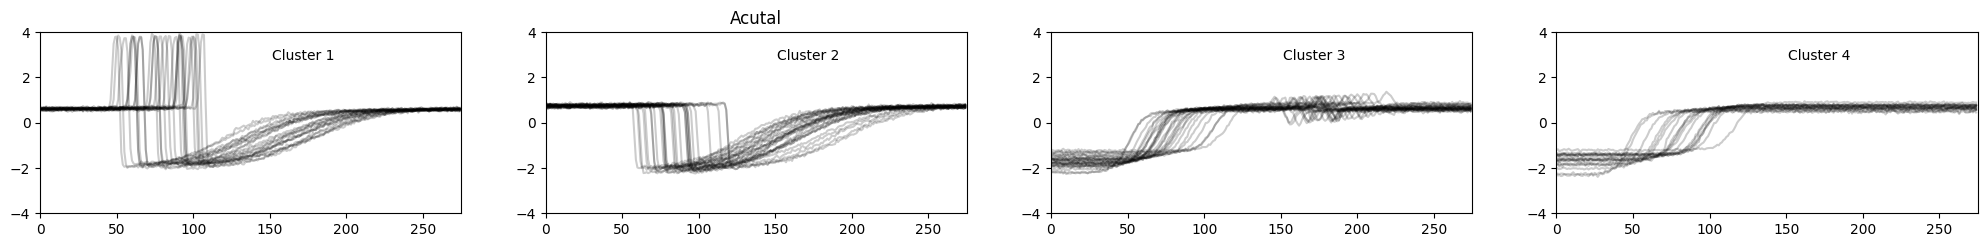

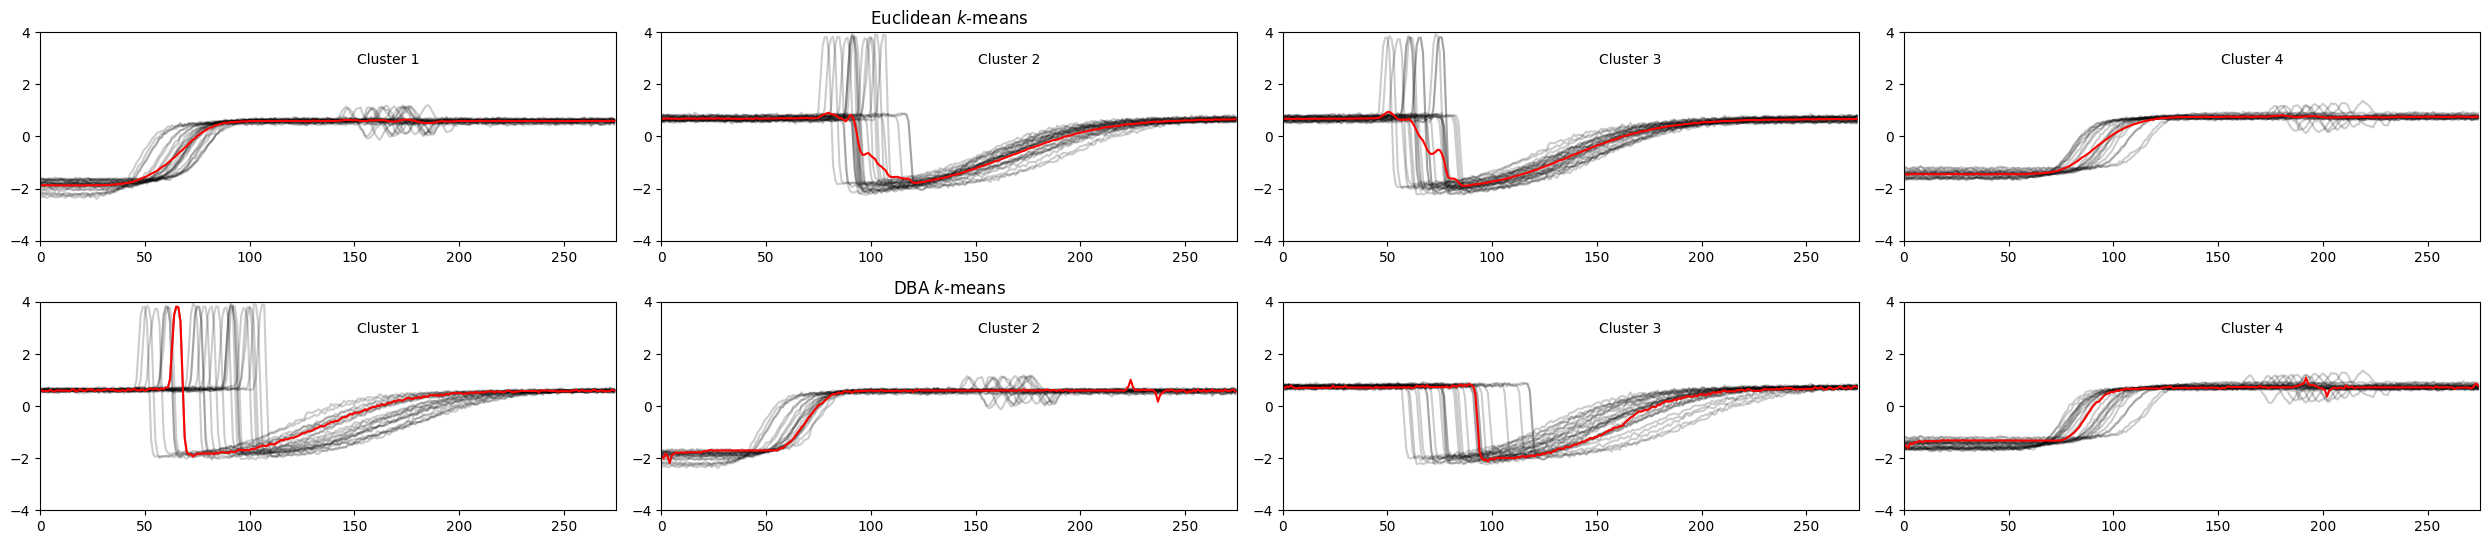

In [30]:
n_clusters = 4

## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_test[y_test == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")


# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X_test)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_test[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_test)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, 5 + yi)
    for xx in X_test[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")



plt.tight_layout()
plt.show()

In [31]:
from sklearn import metrics

print("Adjusted Rand Index for Euclidean: {:.2f}".format(metrics.adjusted_rand_score(y_test, y_pred_km)))
print("Adjusted Rand Index for DBA : {:.2f}".format(metrics.adjusted_rand_score(y_test, y_pred_dba_km)))

Adjusted Rand Index for Euclidean: 0.33
Adjusted Rand Index for DBA : 0.70
